In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from scipy import stats

# Local python modules are not imported into the virtual environment right now...
# This is a slightly kludgey way to import modules without formally packaging them
import sys
sys.path.append('../src/') 
from utils import load_metadata_pandas, load_processed_pandas

ModuleNotFoundError: No module named 'utils'

In [ ]:
df_traffic = load_processed_pandas()
df_meta = load_metadata_pandas()

merged = pd.merge(df_traffic, df_meta, on='LocationID', how='inner')
valid_ids = merged['LocationID'].unique()
df_meta = df_meta[df_meta['LocationID'].isin(valid_ids)].copy()

In [3]:
valid_dirs = ['NB', 'SB', 'EB', 'WB']
mask = (
    (df_traffic['LocationID'].isin(valid_ids)) &
    (df_traffic['Direction'].isin(valid_dirs)) &
    (df_traffic['Lane'].isna())
)
df_traffic = df_traffic[mask].copy()

In [4]:
def remove_hourly_outliers(df, lower_quantile=0.05, upper_quantile=0.95):
    """
    Remove extreme outliers in the 'Volume' column for each hour group in the DataFrame.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least the columns 'Hour' and 'Volume'.
    lower_quantile : float, optional
        Lower quantile threshold (default 0.05).
    upper_quantile : float, optional
        Upper quantile threshold (default 0.95).
    
    Returns
    -------
    df_filtered : pandas.DataFrame
        DataFrame with outliers removed from each hour group.
    """
    def filter_group(group):
        lower = group['Volume'].quantile(lower_quantile)
        upper = group['Volume'].quantile(upper_quantile)
        return group[(group['Volume'] >= lower) & (group['Volume'] <= upper)]
    
    df_filtered = df.groupby('Hour', group_keys=False).apply(filter_group)
    return df_filtered

In [5]:
def gam(location_id, direction, start='2018-01-01', end='2025-01-01'):
    filtered_df = df_traffic[
        (df_traffic['LocationID'] == location_id) &
        (df_traffic['Direction'] == direction) &
        (df_traffic['DateTime'] >= start) &
        (df_traffic['DateTime'] <= end) &
        (df_traffic['Weekend'] == False)
    ].copy()
    
    X = filtered_df[['Hour']]  # Predictor must be 2D
    y = filtered_df['Volume']
    
    spline = SplineTransformer(degree=2, n_knots=15, include_bias=False)
    model = LinearRegression()
    pipeline = make_pipeline(spline, model)
    
    pipeline.fit(X.values, y.values)
    
    hour_new = np.linspace(0, 23, 240).reshape(-1, 1)
    y_pred = pipeline.predict(hour_new)
    
    # -------------------------
    # 5. Compute the 95% Prediction Intervals
    # -------------------------
    # We need to work with the design matrix (the spline-transformed features).
    # Extract the spline transformer from the pipeline.
    spline_transformer = pipeline.named_steps['splinetransformer']
    
    # Get the transformed design matrix for the training data and new data.
    X_design_train = spline_transformer.transform(X.values)       # Training design matrix
    X_design_new   = spline_transformer.transform(hour_new)  # New design matrix
    
    # Compute the inverse of (X^T X)
    A = np.linalg.inv(X_design_train.T @ X_design_train)
    n, p = X_design_train.shape
    
    # Estimate the residual variance from training data
    y_train_pred = pipeline.predict(X.values)
    residuals = y - y_train_pred
    sigma2 = np.sum(residuals ** 2) / (n - p)  # Unbiased estimator
    
    # t-statistic for a 90% prediction interval (two-tailed)
    t_val = stats.t.ppf(0.95, df=n - p)
    
    # For each new point, compute the standard error of prediction:
    #   se = sqrt( sigma^2 * (1 + x_new^T A x_new) )
    pred_se = np.array([
        np.sqrt(sigma2 * (1 + x_new.dot(A).dot(x_new)))
        for x_new in X_design_new
    ])
    
    # Compute the lower and upper prediction bounds.
    y_lower = y_pred - t_val * pred_se
    y_upper = y_pred + t_val * pred_se
    
    return y_pred, y_lower, y_upper, filtered_df


In [6]:
def gam_poisson(location_id, direction, start='2018-01-01', end='2025-01-01'):
    filtered_df = df_traffic[
        (df_traffic['LocationID'] == location_id) &
        (df_traffic['Direction'] == direction) &
        (df_traffic['DateTime'] >= start) &
        (df_traffic['DateTime'] <= end) &
        (df_traffic['Weekend'] == False)
    ].copy()
    
    # -------------------------
    # 2. Prepare the data
    # -------------------------
    # Use 'Hour' as the predictor and 'Volume' as the response.
    X = filtered_df[['Hour']]  # Predictor must be 2D
    y = filtered_df['Volume']
    
    # -------------------------
    # 3. Build the model pipeline
    # -------------------------
    # The SplineTransformer creates spline basis functions.
    # Here we use cubic splines (degree=3) with 10 knots. Adjust as needed.
    spline = SplineTransformer(degree=2, n_knots=15, include_bias=False)
    model = PoissonRegressor()
    pipeline = make_pipeline(spline, model)
    
    # Fit the model on the data.
    pipeline.fit(X.values, y.values)
    
    # -------------------------
    # 4. Make predictions over a grid of hours
    # -------------------------
    # Create a dense grid from hour 0 to 23 to visualize the fitted curve.
    hour_new = np.linspace(0, 23, 240).reshape(-1, 1)
    y_pred = pipeline.predict(hour_new)
    
    # -------------------------
    # 5. Compute the 95% Prediction Intervals
    # -------------------------
    # We need to work with the design matrix (the spline-transformed features).
    # Extract the spline transformer from the pipeline.
    spline_transformer = pipeline.named_steps['splinetransformer']
    
    # Get the transformed design matrix for the training data and new data.
    X_design_train = spline_transformer.transform(X.values)       # Training design matrix
    X_design_new   = spline_transformer.transform(hour_new)  # New design matrix
    print(X_design_new)
    
    # Compute the inverse of (X^T X)
    A = np.linalg.inv(X_design_train.T @ X_design_train)
    n, p = X_design_train.shape
    
    # Estimate the residual variance from training data
    y_train_pred = pipeline.predict(X.values)
    residuals = y - y_train_pred
    sigma2 = np.sum(residuals ** 2) / (n - p)  # Unbiased estimator
    
    # t-statistic for a 90% prediction interval (two-tailed)
    t_val = stats.t.ppf(0.95, df=n - p)
    
    # For each new point, compute the standard error of prediction:
    #   se = sqrt( sigma^2 * (1 + x_new^T A x_new) )
    pred_se = np.array([
        np.sqrt(sigma2 * (1 + x_new.dot(A).dot(x_new)))
        for x_new in X_design_new
    ])
    
    # Compute the lower and upper prediction bounds.
    y_lower = y_pred - t_val * pred_se
    y_upper = y_pred + t_val * pred_se
    
    return y_pred, y_lower, y_upper, filtered_df


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
import torch

def gam_bayes_sklearn_torch(location_id, direction, start='2018-01-01', end='2025-01-01', n_samples=1000, epsilon=1, alpha=1e-2, degree=2, n_knots=15):
    """
    Fits a GAM using a spline basis and linear regression on the log-transformed volume,
    then uses Torch to compute the Hessian of the mean-squared error loss with respect
    to the regression parameters. Interpreting the (scaled) inverse Hessian as an
    approximate posterior covariance, the function draws samples from the posterior,
    computes predictions on a grid of hours, and then produces Bayesian prediction
    intervals (after exponentiating back to the original volume scale).
    
    Parameters
    ----------
    location_id : numeric or string
        Identifier for the location.
    direction : string
        Traffic direction (e.g., 'N', 'S', etc.).
    start : str, optional
        Start date (default '2018-01-01').
    end : str, optional
        End date (default '2025-01-01').
    n_samples : int, optional
        Number of parameter samples to draw (default 1000).
    
    Returns
    -------
    mean_pred : array, shape (n_new,)
        The mean predicted volume (after exponentiating) on a grid of hours (0 to 23).
    bands : dict
        A dictionary with keys 0.80, 0.90, and 0.95. Each value is a tuple (lower, upper)
        giving the corresponding prediction interval (on the original scale).
    filtered_df : pandas.DataFrame
        The subset of df_traffic used for training.
    pipeline : sklearn.pipeline.Pipeline
        The fitted pipeline (with the SplineTransformer and LinearRegression).
    H_np : ndarray
        The Hessian (of the loss function with respect to the regression parameters)
        computed using Torch.
    """
    # --- 1. Filter the data ---
    # (Assumes your global DataFrame is named `df_traffic` with columns:
    #  'LocationID', 'Direction', 'DateTime', 'Weekend', 'Hour', 'Volume')
    filtered_df = df_traffic[
        (df_traffic['LocationID'] == location_id) &
        (df_traffic['Direction'] == direction) &
        (df_traffic['DateTime'] >= start) &
        (df_traffic['DateTime'] <= end) &
        (df_traffic['Weekend'] == False)
    ].copy()
    filtered_df = remove_hourly_outliers(filtered_df)
    # --- 2. Prepare the data ---
    # Predictor: Hour (2D array); Response: Volume (we will log-transform)
    X = filtered_df[['Hour']].values  # shape (n_samples, 1)
    y = filtered_df['Volume'].values + 1.0   # counts; 
    y_log = np.log(y)                   # take natural log
    
    # --- 3. Build and fit the model pipeline ---
    # We'll use a SplineTransformer to create a spline basis.
    # To incorporate an intercept in the linear model, we set include_bias=True
    # and use LinearRegression with fit_intercept=False.
    spline = SplineTransformer(degree=degree, n_knots=n_knots, include_bias=True)
    model = Ridge(alpha=alpha, fit_intercept=False)
    pipeline = make_pipeline(spline, model)
    pipeline.fit(X, y_log)  # training on log(y)
    
    # --- 4. Retrieve the design matrix and fitted coefficients ---
    # Get the design matrix from the fitted spline transformer.
    X_design = pipeline.named_steps['splinetransformer'].transform(X)  # shape: (n_samples, d)
    # Get the fitted parameters (coefficient vector) from the linear model.
    w = pipeline.named_steps['ridge'].coef_  # shape: (d,)
    
    # Compute the training predictions and MSE in log-space.
    y_log_pred = pipeline.predict(X)
    mse = np.mean((y_log - y_log_pred) ** 2)  # our estimate of sigma^2
    
    # --- 5. Use Torch to compute the Hessian of the MSE loss with respect to w ---
    # Convert the design matrix and targets to torch tensors.
    X_torch = torch.tensor(X_design, dtype=torch.float32)
    y_torch = torch.tensor(y_log, dtype=torch.float32)
    # Create a torch tensor for the parameters, initialized from w.
    w_torch = torch.tensor(w, dtype=torch.float32, requires_grad=True)
    
    # Define the loss function (mean squared error)
    def loss_fn(w_param):
        # w_param is a tensor of shape (d,)
        pred = X_torch.matmul(w_param)
        err = pred - y_torch
        loss = err.inner(err) + alpha * w_param.inner(w_param)
        return loss
    
    # Compute the Hessian using Torch's autograd.functional.hessian.
    H = torch.autograd.functional.hessian(loss_fn, w_torch)
    H_np = H.detach().numpy() # convert to NumPy array
    
    # --- 6. Approximate posterior covariance and sample parameter vectors ---
    # Under a Laplace approximation, we interpret the (scaled) inverse Hessian as the
    # posterior covariance. (Here we scale by the training MSE.)
    cov_params = (1.0 / epsilon) * np.linalg.inv(H_np)
    np.set_printoptions(precision=3)
    np.set_printoptions(linewidth=1000)
    print(cov_params)
    print(np.diag(cov_params))
    print(w)
    eigs = np.linalg.eigvalsh(cov_params)
    plt.plot(eigs)
    
    # Draw n_samples samples of the parameter vector from the multivariate normal.
    beta_samples = np.random.multivariate_normal(mean=w, cov=cov_params, size=n_samples)
    
    # --- 7. Make predictions on a grid of hours using the sampled parameters ---
    hour_new = np.linspace(0, 23, 240).reshape(-1, 1)  # grid of hours (0 to 23)
    # Compute the new design matrix from the fitted spline transformer.
    X_new_design = pipeline.named_steps['splinetransformer'].transform(hour_new)  # shape: (n_new, d)
    
    # Compute predicted log-volumes for each sample.
    # (This gives an array of shape (n_new, n_samples).)
    preds_log_samples = np.dot(X_new_design, beta_samples.T)
    # Exponentiate to recover predictions on the original volume scale.
    preds_samples = np.exp(preds_log_samples)
    
    # Also compute the mean prediction using the fitted pipeline.
    mean_pred_log = pipeline.predict(hour_new)
    mean_pred = np.exp(mean_pred_log)
    
    # --- 8. Compute prediction intervals from the posterior predictive samples ---
    conf_levels = [0.95]
    bands = {}
    for conf in conf_levels:
        lower_pct = (1 - conf) / 2 * 100
        upper_pct = (1 + conf) / 2 * 100
        lower = np.percentile(preds_samples, lower_pct, axis=1)
        upper = np.percentile(preds_samples, upper_pct, axis=1)
        bands[conf] = (lower, upper)

    results = {
        'hour_new': hour_new,
        'mean_pred': mean_pred,
        'bands': bands,
        'filtered_df': filtered_df,
    }
    return results
    #return mean_pred, bands, filtered_df, pipeline, H_np

# =============================================================================
# Example usage:
#
# Assuming your DataFrame is named `df_traffic` and contains columns:
# 'LocationID', 'Direction', 'DateTime', 'Weekend', 'Hour', 'Volume'
#
# You can then run:
#
# mean_pred, bands, filtered_df, pipeline, H_np = gam_bayes_sklearn_torch(
#     location_id=101, direction='N', start='2018-01-01', end='2025-01-01', n_samples=1000
# )
#
# And then plot the results as desired. For example:
#
# import matplotlib.pyplot as plt
#
# hour_new = np.linspace(0, 23, 240)
# plt.figure(figsize=(20,6))
# plt.scatter(filtered_df['Hour'], filtered_df['Volume'], color='black', alpha=0.1, label='Data')
# plt.plot(hour_new, mean_pred, color='blue', lw=2, label='Mean Prediction')
# for conf, (lower, upper) in bands.items():
#     plt.fill_between(hour_new, lower, upper, alpha={0.95:0.1, 0.90:0.3, 0.80:0.5}[conf],
#                      label=f'{int(conf*100)}% Prediction Interval')
# plt.xlabel('Hour of Day')
# plt.ylabel('Volume (Number of Cars)')
# plt.title('GAM with Bayesian Prediction Intervals (via log-transform & Torch Hessian)')
# plt.legend()
# plt.show()
# =============================================================================


[[0.5        0.5        0.         ... 0.         0.         0.        ]
 [0.44313825 0.55514609 0.00171566 ... 0.         0.         0.        ]
 [0.38970781 0.60342956 0.00686262 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00686262 0.60342956]
 [0.         0.         0.         ... 0.         0.00171566 0.55514609]
 [0.         0.         0.         ... 0.         0.         0.5       ]]


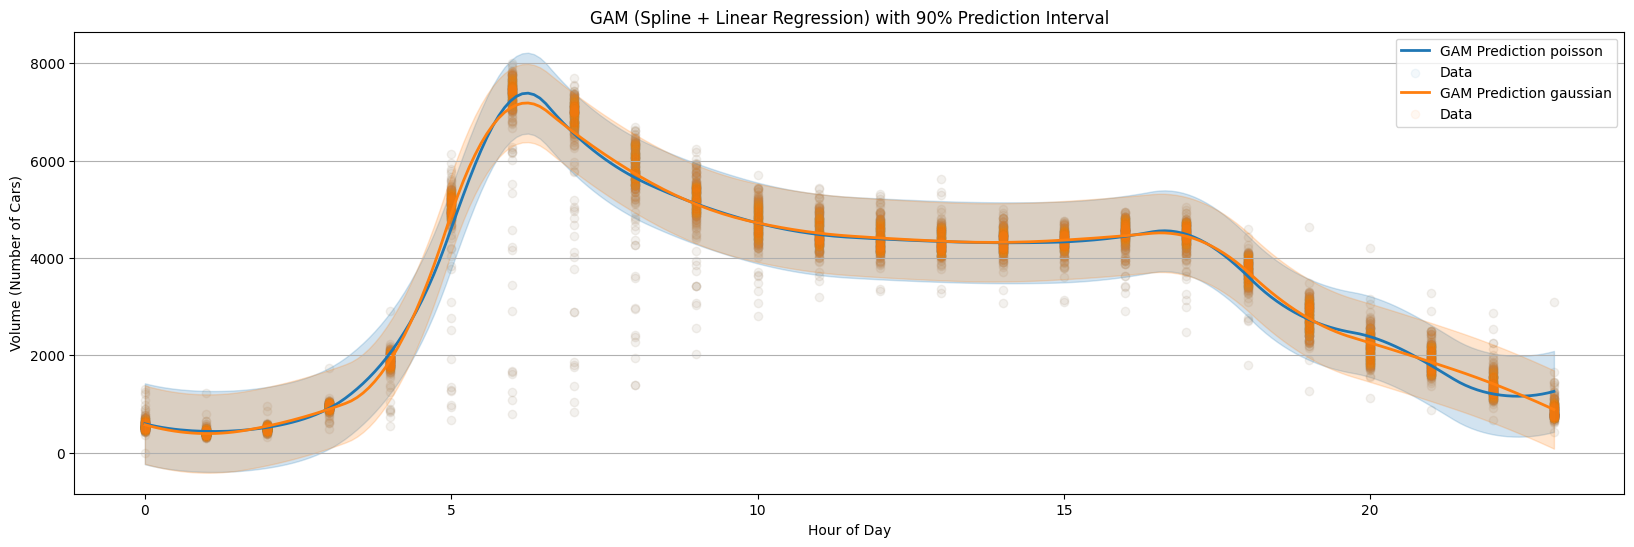

In [10]:
location_id = 26024
direction = 'SB'
start='2018-01-01'
end='2019-01-01'
pre_poisson = gam_poisson(location_id, direction, start=start, end=end)
pre_gaussian = gam(location_id, direction, start=start, end=end)
plot_multi([pre_poisson, pre_gaussian], ["poisson", "gaussian"])

In [11]:
location_id = 26024
direction = 'SB'
start='2023-01-01'
end='2024-01-01'
post = gam(location_id, direction, start=start, end=end)

In [12]:
def plot_multi(datas, names):
    hour_new = np.linspace(0, 23, 240).reshape(-1, 1)
    plt.figure(figsize=(20, 6))
    plt.title('GAM (Spline + Linear Regression) with 90% Prediction Interval')

    for i, (data, name) in enumerate(zip(datas, names)):
        plt.plot(hour_new, data[0], label=f'GAM Prediction {name}', color=f'C{i}', lw=2)
        plt.scatter(data[3]['Hour'], data[3]['Volume'], label='Data', color=f'C{i}', alpha=0.05)
        plt.fill_between(hour_new.flatten(), data[1], data[2], color=f'C{i}', alpha=0.2)

    plt.grid(axis='y') 
    plt.xlabel('Hour of Day')
    plt.ylabel('Volume (Number of Cars)')
    plt.legend()
    plt.show()

In [13]:
plot_multi([pre, post], ["pre", "post"])

NameError: name 'pre' is not defined

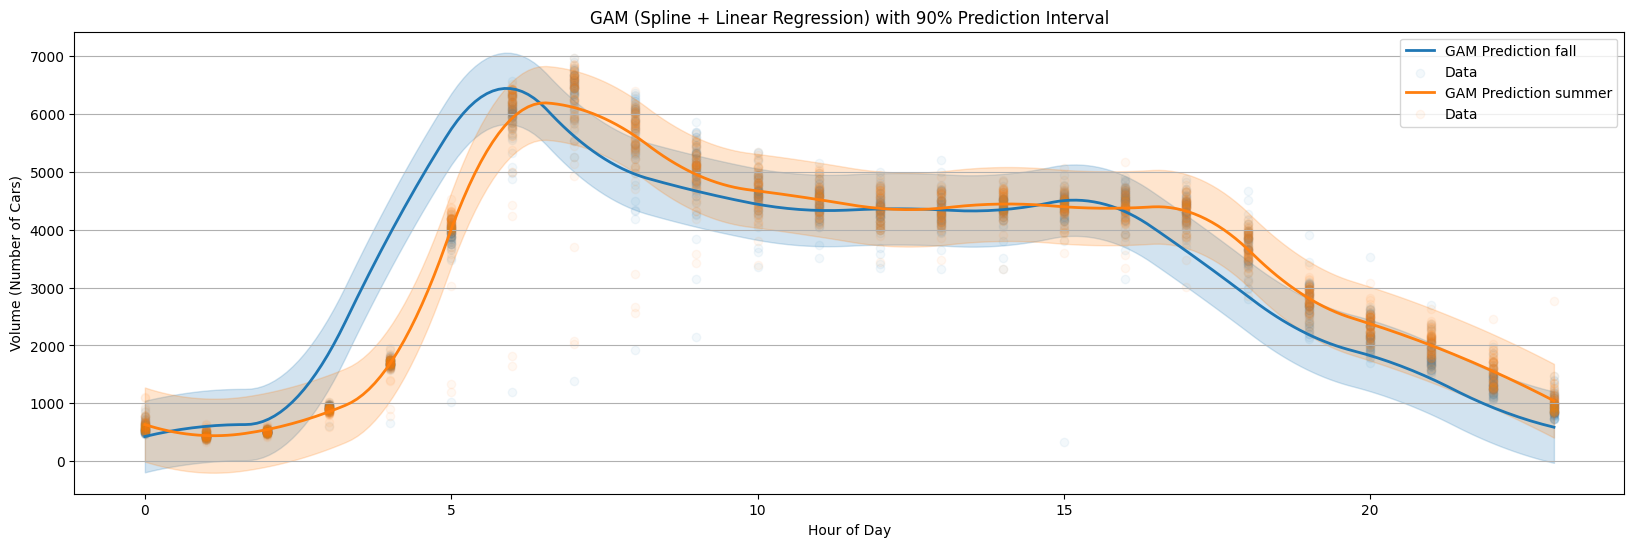

In [14]:
location_id = 26024
direction = 'SB'
start1='2024-08-01'
end1='2024-12-01'
start2='2024-04-01'
end2='2024-08-01'
fall = gam(location_id, direction, start=start1, end=end1)
fall[3]['Hour'] = (fall[3]['Hour'] + 1) % 24
summer = gam(location_id, direction, start=start2, end=end2)
plot_multi([fall, summer], ["fall", "summer"])

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
from scipy.stats import norm

def plot_gam_results(gam_results, location_id=None, direction=None, start=None, end=None):
    """
    Plots the results from a GAM fit. The plot includes:
      - The original (filtered) data (if available),
      - The mean prediction from the model,
      - Prediction intervals at 80%, 90%, and 95% (with different opacities).
    
    Parameters
    ----------
    gam_results : dict
        Dictionary returned by fit_gam_bayes containing at least:
          'hour_new', 'mean_pred', and 'bands'.
    location_id, direction, start, end : optional
        These values are used in the plot title.
    """
    hour_new = gam_results['hour_new'].flatten()
    mean_pred = gam_results['mean_pred']
    bands = gam_results['bands']
    
    plt.figure(figsize=(20, 6))
    
    if 'filtered_df' in gam_results:
        df_plot = gam_results['filtered_df']
        plt.scatter(df_plot['Hour'], df_plot['Volume'], label='Data',
                    color='black', alpha=0.03)
    
    plt.plot(hour_new, mean_pred, label='GAM Mean Prediction', color='blue', lw=2)
    
    band_order = [0.95, 0.90, 0.80]
    opacities = {0.95: 0.03, 0.90: 0.06, 0.80: 0.12}
    for conf, bounds in bands.items():
        lower, upper = bounds
        plt.fill_between(hour_new, lower, upper, color='blue', alpha=0.1
                         ,label=f'{int(conf*100)}% Prediction Interval')
    
    plt.xlabel('Hour of Day')
    plt.ylabel('Volume (Number of Cars)')
    plt.grid()
    title = 'GAM Bayesian Prediction Intervals'
    if location_id is not None:
        title += f'\nLocation: {location_id}'
    if direction is not None:
        title += f', Direction: {direction}'
    if start is not None and end is not None:
        title += f'\nDate Range: {start} to {end}'
    plt.title(title)
    plt.legend()
    plt.show()


# =============================================================================
# Example usage:
#
# (Assuming your DataFrame is named `df_traffic` and has the columns:
#  'LocationID', 'Direction', 'DateTime', 'Weekend', 'Hour', 'Volume')
#
# First, call the fitting function:
#
# results = fit_gam_bayes(location_id=101, direction='N',
#                          start='2018-01-01', end='2025-01-01',
#                          n_samples=1000, add_obs_noise=True)
#
# Then, call the plotting function:
#
# plot_gam_results(results, location_id=101, direction='N',
#                  start='2018-01-01', end='2025-01-01')
# =============================================================================


[[ 2.495e+00 -7.069e-02 -6.977e-03  8.638e-03 -5.988e-03  3.870e-03 -2.463e-03  1.567e-03 -1.010e-03  6.757e-04 -4.975e-04  4.553e-04 -5.948e-04 -2.988e-05]
 [-7.069e-02  1.315e+00 -5.269e-01  2.545e-01 -1.399e-01  8.252e-02 -5.050e-02  3.158e-02 -2.020e-02  1.347e-02 -9.900e-03  9.052e-03 -1.182e-02 -5.943e-04]
 [-6.977e-03 -5.269e-01  2.728e-01 -1.592e-01  9.719e-02 -6.038e-02  3.784e-02 -2.393e-02  1.538e-02 -1.027e-02  7.561e-03 -6.917e-03  9.034e-03  4.540e-04]
 [ 8.638e-03  2.545e-01 -1.592e-01  1.304e-01 -9.370e-02  6.247e-02 -4.038e-02  2.588e-02 -1.673e-02  1.121e-02 -8.258e-03  7.560e-03 -9.880e-03 -4.961e-04]
 [-5.988e-03 -1.399e-01  9.719e-02 -9.370e-02  9.887e-02 -7.652e-02  5.251e-02 -3.451e-02  2.255e-02 -1.518e-02  1.121e-02 -1.028e-02  1.344e-02  6.739e-04]
 [ 3.870e-03  8.252e-02 -6.038e-02  6.247e-02 -7.652e-02  8.945e-02 -7.113e-02  4.952e-02 -3.315e-02  2.255e-02 -1.673e-02  1.538e-02 -2.016e-02 -1.007e-03]
 [-2.463e-03 -5.050e-02  3.784e-02 -4.038e-02  5.251e-02 -

/tmp/ipykernel_369870/4010779528.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df.groupby('Hour', group_keys=False).apply(filter_group)


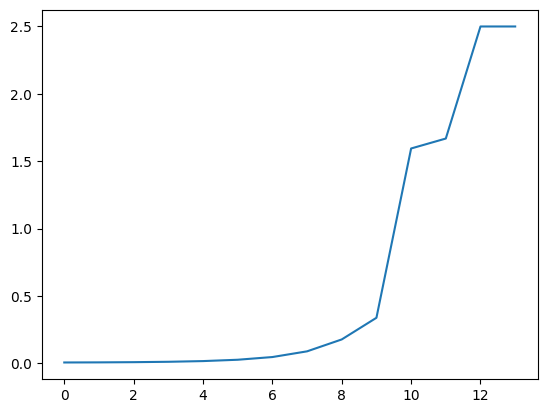

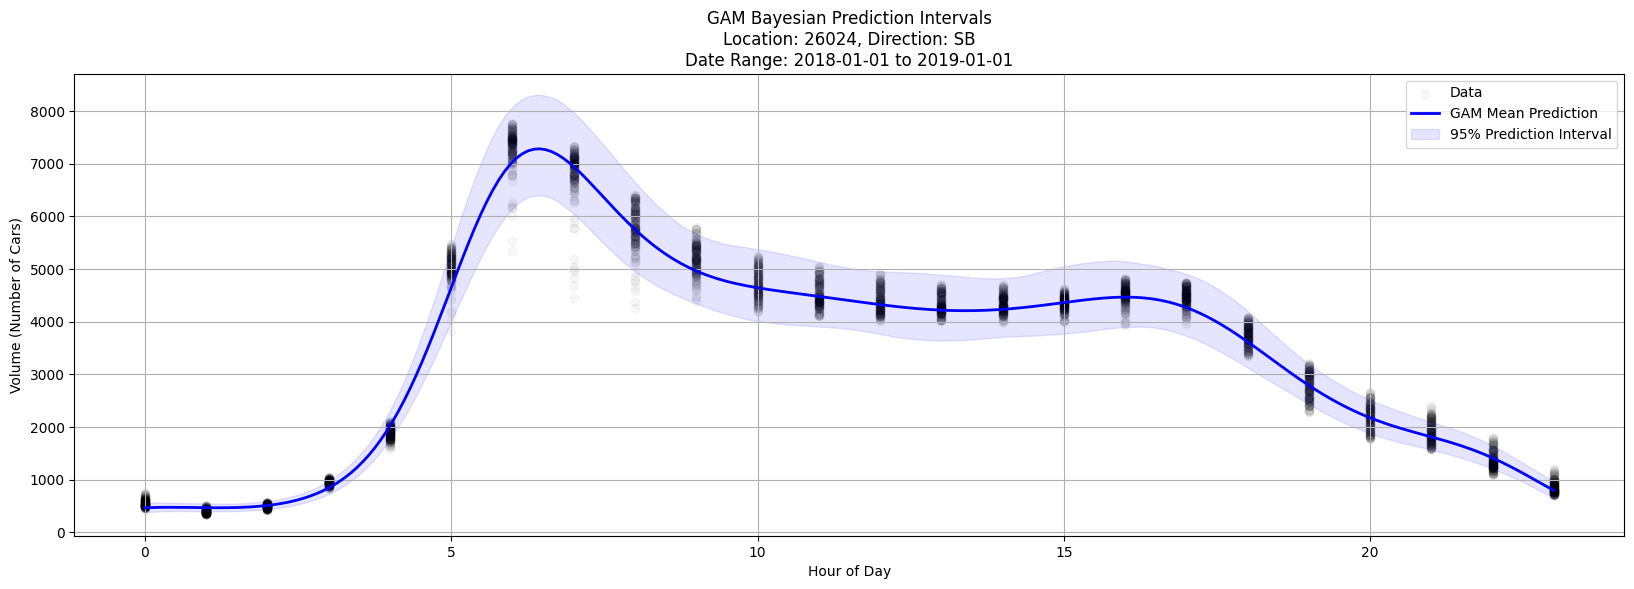

In [22]:
location_id = 26024
direction = 'SB'
start='2018-01-01'
end='2019-01-01'
results = gam_bayes_sklearn_torch(location_id, direction, start=start, end=end, n_samples=10000, epsilon=2e-1, alpha=1, degree=5, n_knots=10)
plot_gam_results(results, location_id=location_id, direction=direction, start=start, end=end)